In [1]:
import os

import dolfinx
import gmsh
import matplotlib.pyplot as plt
import meshio
import numpy as np
import pyvista
import pyvista as pv
import pyvistaqt as pvqt
import ufl
import warnings

from dolfinx import cpp, fem, io, mesh, nls, plot
from dolfinx.fem import petsc
from dolfinx.io import VTXWriter
from dolfinx.nls import petsc as petsc_nls
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 dot, div, dx, ds, dS, grad, inner, grad, avg, jump)

import commons, geometry, utils

warnings.simplefilter('ignore')

In [2]:
encoding = io.XDMFFile.Encoding.HDF5
adaptive_refine = False
run_mesh = False
micron = 1e-6
markers = {
    'ne_pcc': 0,  # boundary not included yet
    'ne_se': 1,  # left boundary
    'pe_se': 2,  # internal boundary
    'pe_pcc': 3,  # left boundary
    'ne': 4,   # domain not included yet
    'se': 5,  # left domain
    'pe': 6,  # right domain
    "insulated_se": 7,  # top and bottom boundary - left
    "insulated_pam": 8,  # top and bottom boundary - right
}
mrkr = {
    "neg_cc_matrix": 1,
    "electrolyte": 2,
    # facets
    "left": 1,
    "right": 2,
    "middle": 3,
    "insulated": 4,
    "insulated_ncc": 5,
    "insulated_sep": 6,
}

workdir = "output/lithium-metal-leb"
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(workdir, 'mesh.msh')
tetr_meshfile = os.path.join(workdir, "tetr.xdmf")
tria_meshfile = os.path.join(workdir, "tria.xdmf")
line_meshfile = os.path.join(workdir, "line.xdmf")
potential_resultsfile = os.path.join(workdir, "potential.bp")
potential_dg_resultsfile = os.path.join(workdir, "potential_dg.bp")
concentration_resultsfile = os.path.join(workdir, "concentration.bp")
current_resultsfile = os.path.join(workdir, "current.bp")

L_sep = 25 * micron
L_neg_cc = 20 * micron
L_sep_neg_cc = 15 * micron
feature_radius = 5 * micron
disk_radius = 100 * micron
L_total = L_sep + L_neg_cc
if run_mesh:
    gmsh.initialize()
    gmsh.model.add('lithium-metal-leb')

    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.5*micron)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", micron)

    neg_cc = gmsh.model.occ.addCylinder(0, 0, 0, 0, 0, L_neg_cc, disk_radius)
    gmsh.model.occ.synchronize()
    sep_main = gmsh.model.occ.addCylinder(0, 0, L_neg_cc, 0, 0, L_sep, disk_radius)
    gmsh.model.occ.synchronize()
    sep_neg_cc = gmsh.model.occ.addCylinder(0, 0, L_neg_cc - L_sep_neg_cc, 0, 0, L_neg_cc, feature_radius)
    gmsh.model.occ.synchronize()
    current_collector = gmsh.model.occ.cut([(3, neg_cc)], [(3, sep_neg_cc)], removeTool=False)
    gmsh.model.occ.synchronize()
    electrolyte = gmsh.model.occ.fuse([(3, sep_main)], [(3, sep_neg_cc)])
    gmsh.model.occ.synchronize()
    
    
    volumes = gmsh.model.occ.getEntities(3)
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(3, [volumes[1][1]], mrkr["electrolyte"])
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(3, [volumes[0][1]], mrkr["neg_cc_matrix"])
    gmsh.model.occ.synchronize()
    surfaces = gmsh.model.occ.getEntities(2)
    left = []
    right = []
    middle = []
    insulated = []
    insulated_ncc = []
    insulated_sep = []
    for surf in surfaces:
        com = gmsh.model.occ.getCenterOfMass(surf[0], surf[1])
        if np.isclose(com[2], 0):
            left.append(surf[1])
        elif np.isclose(com[2], L_total):
            right.append(surf[1])
        elif np.isclose(com[2], L_total - 0.5 * L_sep) or np.isclose(com[2], 0.5 * L_neg_cc):
            if np.isclose(com[2], 0.5 * L_neg_cc):
                insulated_ncc.append(surf[1])
            elif np.isclose(com[2], L_total - 0.5 * L_sep):
                insulated_sep.append(surf[1])
        else:
            middle.append(surf[1])
    insulated = insulated_ncc + insulated_sep
    gmsh.model.addPhysicalGroup(2, left, mrkr["left"])
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, right, mrkr["right"])
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, middle, mrkr["middle"])
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, insulated_ncc, mrkr["insulated_ncc"])
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, insulated_sep, mrkr["insulated_sep"])
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, insulated, mrkr["insulated"])
    gmsh.model.occ.synchronize()
    
    # gmsh.model.occ.dilate(gmsh.model.get_entities(1), 0, 0, 0, micron, micron, micron)
    gmsh.model.occ.synchronize()
    # adaptive refinement
    gmsh.model.mesh.generate(3)
    gmsh.write(output_meshfile)
    gmsh.finalize()
    
    mesh_3d = meshio.read(output_meshfile)
    tetr_mesh = geometry.create_mesh(mesh_3d, "tetra")
    # tetra_mesh = geometry.scale_mesh(tetr_mesh, "tetra", scale_factor=[micron, micron, micron])
    meshio.write(tetr_meshfile, tetr_mesh)
    tria_mesh = geometry.create_mesh(mesh_3d, "triangle")
    # tria_mesh = geometry.scale_mesh(tria_mesh, "triangle", scale_factor=[micron, micron, micron])
    meshio.write(tria_meshfile, tria_mesh)

## Binary Electrolyte - Nernst-Planck Equation

We make the following assumptions
- no bulk flow
- diffusivity not a function of concentration
- binary electrolyte

$$\frac{\partial c}{\partial t} + \pmb{v}\cdot\nabla c - D\nabla^2c=0$$

In [3]:
comm = MPI.COMM_WORLD
with io.XDMFFile(comm, tetr_meshfile, "r") as infile3:
    domain = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
    ct = infile3.read_meshtags(domain, name="Grid")
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, fdim)

ft_imap = domain.topology.index_map(fdim)
num_facets = ft_imap.size_local + ft_imap.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

with io.XDMFFile(comm, tria_meshfile, "r") as infile2:
    ft = infile2.read_meshtags(domain, name="Grid")

values[ft.indices] = ft.values
meshtags = mesh.meshtags(domain, fdim, indices, values)
domaintags = mesh.meshtags(domain, domain.topology.dim, ct.indices, ct.values)

## Solve Potential Problem

In [4]:
dx = ufl.Measure("dx", domain=domain, subdomain_data=domaintags)
ds = ufl.Measure("ds", domain=domain, subdomain_data=meshtags)
dS = ufl.Measure("dS", domain=domain, subdomain_data=meshtags)

In [5]:
V = fem.FunctionSpace(domain, ("DG", 1))
u = fem.Function(V)
v = ufl.TestFunction(V)
n = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)

alpha = 10
gamma = 100

h = ufl.CellDiameter(domain)
h_avg = avg(h)

In [6]:
x = SpatialCoordinate(domain)

f = fem.Constant(domain, PETSc.ScalarType(0))
g = fem.Constant(domain, PETSc.ScalarType(0))
voltage = 1000e-3
u_left = fem.Function(V)
with u_left.vector.localForm() as u0_loc:
    u0_loc.set(0)
u_right = fem.Function(V)
with u_right.vector.localForm() as u1_loc:
    u1_loc.set(voltage)

In [7]:
i0 = fem.Constant(domain, PETSc.ScalarType(1e2))
faraday_const = fem.Constant(domain, PETSc.ScalarType(96485))
R = fem.Constant(domain, PETSc.ScalarType(8.3145))
T = fem.Constant(domain, PETSc.ScalarType(298))
def ocv(sod, L=1, k=2):
    return 2.5 + (1/k) * np.log((L - sod) / sod)
sod = 0.975
U = ufl.as_vector((ocv(sod), 0, 0))
print(ocv(sod))

0.6682191769351773


In [8]:
F = dot(grad(u), grad(v)) * dx - dot(v * n, grad(u)) * ds

# Add DG/IP terms
F += - dot(avg(grad(v)), jump(u, n)) * dS(0) - dot(jump(v, n), avg(grad(u))) * dS(0)
F += (gamma / h_avg) * dot(jump(v, n), jump(u, n)) * dS(0)
F += alpha / h * v * u * ds(mrkr['left']) + alpha / h * v * u * ds(mrkr['right'])

# Internal boundary
F += - dot(avg(grad(v)), (R * T / i0 / faraday_const) * grad(u)('-') + U) * dS(mrkr['middle'])
F += (alpha / h_avg) * dot(jump(v, n), (R * T / i0 / faraday_const) * grad(u)('-') + U) * dS(mrkr['middle'])

# Symmetry
F += - dot(avg(grad(v)), jump(u, n)) * dS(mrkr['middle'])

# Coercivity
F += alpha / h_avg * dot(jump(v, n), jump(u, n)) * dS(mrkr['middle'])

# Nitsche Dirichlet BC terms on left and right boundaries
F += - dot(u * n, grad(v)) * ds(mrkr['left'])
F += u_left * dot(n, grad(v)) * ds(mrkr['left']) - (alpha / h) * u_left * v * ds(mrkr['left'])
F += - dot(u * n, grad(v)) * ds(mrkr['right'])
F += u_right * dot(n, grad(v)) * ds(mrkr['right']) - (alpha / h) * u_right * v * ds(mrkr['right'])

# Nitsche Neumann BC terms on insulated boundary
F += -(h / alpha) * dot(g * n, grad(v)) * ds(mrkr['insulated_ncc'])
F += -g * v * ds(mrkr['insulated_ncc'])
F += -(h / alpha) * dot(g * n, grad(v)) * ds(mrkr['insulated_sep'])
F += -g * v * ds(mrkr['insulated_sep'])

# Source term
F += -f * v * dx 

In [9]:
problem = petsc.NonlinearProblem(F, u)
solver = petsc_nls.NewtonSolver(comm, problem)
solver.convergence_criterion = "residual"

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts['maximum_iterations'] = 100
ksp.setFromOptions()
solver.solve(u)
u.name = 'potential'

V_CG1 = fem.FunctionSpace(domain, ("CG", 1))
u_cg = fem.Function(V_CG1)
u_cg.name = 'potential'
u_cg.interpolate(u)

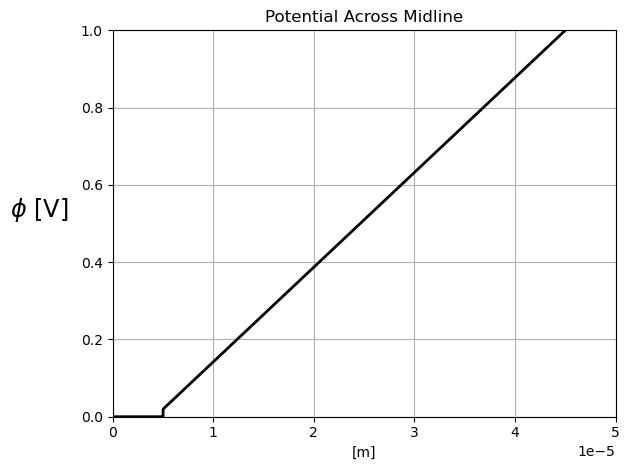

In [10]:
bb_trees = bb_tree(domain, domain.topology.dim)
n_points = 10000
tol = 1e-8  # Avoid hitting the outside of the domain
x = y = np.zeros(n_points)
z = np.linspace(0 + tol, 45e-6 - tol, n_points)# midline
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
points[2] = z
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = compute_collisions_points(bb_trees, points.T)
# Choose one of the cells that contains the point
colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig, ax = plt.subplots()
ax.plot(points_on_proc[:, 2], u_values, "k", linewidth=2)
ax.grid(True)
ax.set_xlim([0, 50e-6])
ax.set_ylim([0, voltage])
ax.set_ylabel(r'$\phi$ [V]', rotation=0, labelpad=30, fontsize='xx-large')
ax.set_xlabel('[m]')
ax.set_title('Potential Across Midline')
plt.tight_layout()
plt.show()

## Concentration Problem

In [11]:
full_mesh, cell_tags, facet_tags = dolfinx.io.gmshio.read_from_msh(output_meshfile, comm, 0)

# Create submesh for pe
pam_domain, entity_map, vertex_map, geom_map = dolfinx.mesh.create_submesh(full_mesh, full_mesh.topology.dim, cell_tags.indices[(cell_tags.values == mrkr['electrolyte'])])

# Transfer facet tags from parent mesh to submesh
tdim = full_mesh.topology.dim
fdim = tdim - 1
c_to_f = full_mesh.topology.connectivity(tdim, fdim)
f_map = full_mesh.topology.index_map(fdim)
all_facets = f_map.size_local + f_map.num_ghosts
all_values = np.zeros(all_facets, dtype=np.int32)
all_values[facet_tags.indices] = facet_tags.values

pam_domain.topology.create_entities(fdim)
subf_map = pam_domain.topology.index_map(fdim)
pam_domain.topology.create_connectivity(tdim, fdim)
c_to_f_sub = pam_domain.topology.connectivity(tdim, fdim)
num_sub_facets = subf_map.size_local + subf_map.num_ghosts
sub_values = np.empty(num_sub_facets, dtype=np.int32)
for i, entity in enumerate(entity_map):
    parent_facets = c_to_f.links(entity)
    child_facets = c_to_f_sub.links(i)
    for child, parent in zip(child_facets, parent_facets):
        sub_values[child] = all_values[parent]
sub_meshtag = dolfinx.mesh.meshtags(pam_domain, pam_domain.topology.dim - 1, np.arange(
    num_sub_facets, dtype=np.int32), sub_values)
pam_domain.topology.create_connectivity(pam_domain.topology.dim - 1, pam_domain.topology.dim)

with dolfinx.io.XDMFFile(comm, "submesh.xdmf", "w", encoding=encoding) as xdmf:
    xdmf.write_mesh(pam_domain)
    xdmf.write_meshtags(sub_meshtag, x=pam_domain.geometry)

Info    : Reading 'output/lithium-metal-leb/mesh.msh'...
Info    : 32 entities
Info    : 554 nodes
Info    : 2610 elements
Info    : Done reading 'output/lithium-metal-leb/mesh.msh'


In [12]:
c_init = 1000  # mol/m3
t = 0 # Start time
eps = 1e-15
dt = 1e-12
T = 500 * dt

dx = ufl.Measure("dx", domain=pam_domain)
ds = ufl.Measure("ds", domain=pam_domain, subdomain_data=sub_meshtag)
dS = ufl.Measure("dS", domain=pam_domain, subdomain_data=sub_meshtag)
n = ufl.FacetNormal(pam_domain)
tdim = pam_domain.topology.dim
fdim = tdim - 1

# Create boundary condition
# boundary_facets = sub_meshtag.find(mrkr['middle'])
# bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(Q, fdim, boundary_facets), Q)

Q = fem.FunctionSpace(pam_domain, ("CG", 1))
c_n = fem.Function(Q)
c_n.name = "c_n"
c_n.interpolate(lambda x:  x[0] - x[0] + c_init)
c_n.x.scatter_forward()

potential = fem.Function(Q)
padding = 1e-16
u1_2_u2_nmm_data = \
        fem.create_nonmatching_meshes_interpolation_data(
            potential.function_space.mesh._cpp_object,
            potential.function_space.element,
            u_cg.function_space.mesh._cpp_object, padding=padding)

potential.interpolate(u, nmm_interpolation_data=u1_2_u2_nmm_data)
potential.x.scatter_forward()

ch = fem.Function(Q)
ch.name = "concentration"
ch.interpolate(lambda x: x[0] - x[0] + c_init)
ch.x.scatter_forward()

c = ufl.TrialFunction(Q)
q = ufl.TestFunction(Q)

f = fem.Constant(pam_domain, PETSc.ScalarType(0))
g = fem.Constant(pam_domain, PETSc.ScalarType(0))
g_middle = fem.Constant(pam_domain, PETSc.ScalarType(0))
D = fem.Constant(pam_domain, PETSc.ScalarType(1e-5))

a = c * q * dx + dt * ufl.inner(D * ufl.grad(c), ufl.grad(q)) * dx
L = (
    (c_n + dt * f) * q * dx 
    + dt * ufl.inner(g, q) * ds(mrkr['insulated_sep']) 
    + dt * ufl.inner(g, q) * ds(mrkr['right'])
    + dt * ufl.inner(ufl.grad(potential) / 96485, n) * q * ds(mrkr['middle'])
)

bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = petsc.assemble_matrix(bilinear_form, bcs=[])
A.assemble()
b = fem.petsc.create_vector(linear_form)

solver = PETSc.KSP().create(comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

c_vtx = VTXWriter(comm, concentration_resultsfile, [ch], engine="BP4")
c_vtx.write(0.0)
count = 0
while t < T:
    count += 1
    if count < 10:
        c_avg = fem.assemble_scalar(fem.form(ch * dx)) / fem.assemble_scalar(fem.form(1 * dx))
        print(f"average concentration: {c_avg}")
    t += dt

    A = fem.petsc.assemble_matrix(fem.form(a), bcs=[])
    A.assemble()
    solver.setOperators(A)

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [])

    # Solve linear problem
    solver.solve(b, ch.vector)
    ch.x.scatter_forward()
    # c_avg = fem.assemble_scalar(fem.form(ch * dx)) / fem.assemble_scalar(fem.form(1 * dx))
    # print(f"average concentration: {c_avg}")

    # Update solution at previous time step (c_n)
    if np.any(ch.x.array < 0):
        print(f"Lithium depletion at {t:.2e} seconds")
        break
    c_n.x.array[:] = ch.x.array
    c_vtx.write(t)
c_vtx.close()

average concentration: 1000.0000000000008
average concentration: inf
average concentration: inf
average concentration: inf
average concentration: inf
average concentration: inf
average concentration: inf
average concentration: inf
average concentration: inf


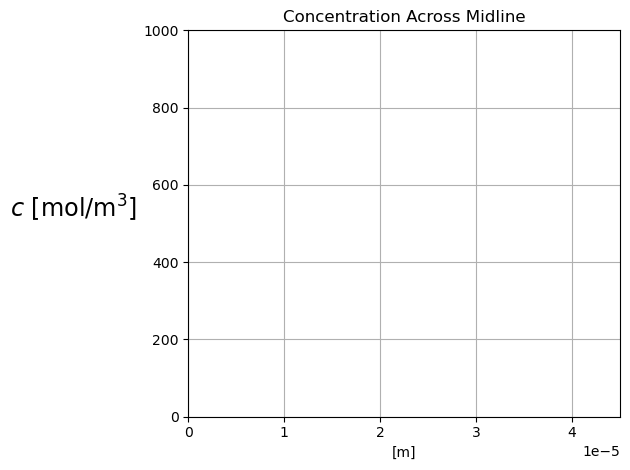

In [13]:
# visualization
bb_trees = bb_tree(pam_domain, pam_domain.topology.dim)
n_points = 10000
tol = 1e-8  # Avoid hitting the outside of the domain
# x = np.linspace(100e-6 + tol, 200e-6 - tol, n_points)
# y = np.ones(n_points) * 0.5 * 5 * 50e-6  # midline
x = y = np.zeros(n_points)
z = np.linspace(0 + tol, 45e-6 - tol, n_points)# midline
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
points[2] = z
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = compute_collisions_points(bb_trees, points.T)
# Choose one of the cells that contains the point
colliding_cells = compute_colliding_cells(pam_domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = ch.eval(points_on_proc, cells)
fig, ax = plt.subplots()
ax.plot(points_on_proc[:, 2], u_values, "k", linewidth=2)
ax.grid(True)
ax.set_xlim([0, 45e-6])
ax.set_ylim([0, c_init])
# ax.set_ylim([0, voltage])
ax.set_ylabel(r'$c$ [mol/m$^3$]', rotation=0, labelpad=50, fontsize='xx-large')
ax.set_xlabel('[m]')
ax.set_title('Concentration Across Midline')
plt.tight_layout()
plt.show()